In [2]:
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::requests==2.22.0=py37_1
  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/linux-64::nb_conda==2.2.1=py37_0
  - defaults/linux-64::s3transfer==0.2.1=py37_0
  - defaults/noarch::ipywidgets==7.5.1=py_0
  - defaults/noarch::s3fs==0.4.2=py_0
  - defaults/linux-64::notebook==6.0.3=py37_0
  - defaults/linux-64::anaconda-client==1.7.2=py37_0
  - defaults/linux-64::widgetsnbextension==3.5.1=py37_0
  - defaults/linux-64::nb_conda_kernels==2.2.4=py37_0
  - defaults/noarch::sphinx==2.4.0=py_0
  - defaults/linux-64::jupyter==1.0.0=py37_7
  - defaults/noarch::botocore==1.12.189=py_0
  - defaults/noarch::jupyterlab_server==1.0.6=py_0
  - defaults/noarch::jupyterlab==1.2.6=pyhf63ae98_0
  - defaults/linux-64::nbconvert==5.6.1=py37_0
  - fastai/noarch::fastprogress==1.0.0=pyh39e3cac_0
  - defaults/linux-64::python-language-ser

In [1]:
!pwd

/home/ubuntu/efs/clip_playground_zahid/CLIP/notebooks



Ground truth:  driver talking on the phone in right hand while driving a car

Top 5 predictions:

driver talking on the phone in left hand while driving a car: 28.30%
driver texting on the phone in left hand while driving a car: 26.59%
driver talking on the phone in right hand while driving a car: 20.07%
driver texting on the phone in right hand while driving a car: 14.01%
driver talking to passenger while driving a car: 8.50%

Ground truth:  driver texting on the phone in left hand while driving a car

Top 5 predictions:

driver texting on the phone in left hand while driving a car: 67.63%
driver texting on the phone in right hand while driving a car: 28.64%
driver talking on the phone in left hand while driving a car: 1.20%
driver talking on the phone in right hand while driving a car: 0.89%
driver talking to passenger while driving a car: 0.66%

Ground truth:  driver talking on the phone in left hand while driving a car

Top 5 predictions:

driver texting on the phone in left hand 

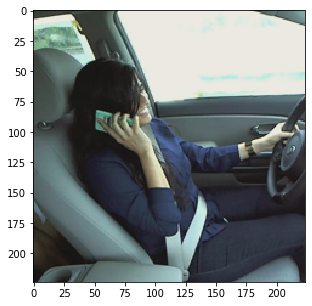

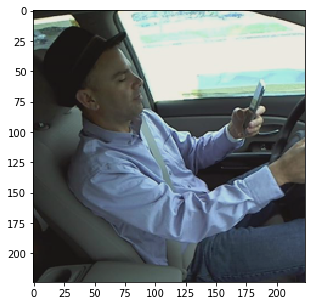

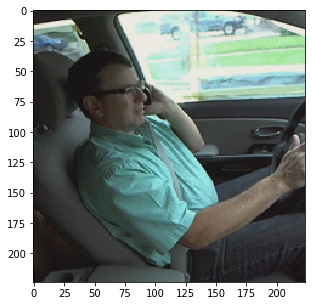

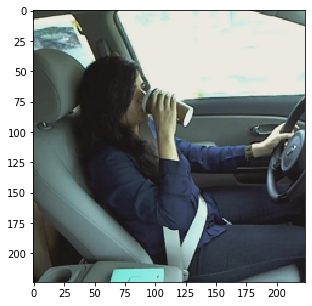

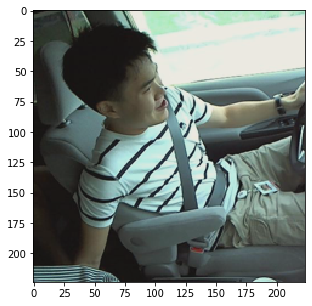

In [2]:
import os
import clip
import torch
import os
import clip
import torch
from torchvision import transforms, datasets
from PIL import Image
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torchvision
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm import tqdm


# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)
df=[]

# Load the dataset
data_dir = 'video/imgs/train/'
image_datasets = datasets.ImageFolder(data_dir, transform=preprocess)

train, val = torch.utils.data.random_split(image_datasets, [18000, 4424])
class_names = image_datasets.classes

for i in range(5000,5005):
    # Prepare the inputs
    image, class_id = train[i]


    def imshow(inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        figure(figsize=(5,5))
        plt.imshow(inp)
        
    imshow(image) 
    print("\nGround truth: ", class_names[class_id])



    image_input = image.unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a{c}") for c in class_names]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

    # Print the result
    print("\nTop 5 predictions:\n")
    for value, index in zip(values, indices):
        print(f"{class_names[index]:>16s}: {100 * value.item():.2f}%")